In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.stats.multitest as multi
import pickle
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.weight'] = 'bold'

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

C:\Users\Jake\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pal = sns.cubehelix_palette(20, rot=-.25, light=0.7)

In [3]:
df_rel_sort_list = pickle.load(open('pickle_files/rel_sort_lod_list_paired.pkl', 'rb'))
df_abs_sort_list = pickle.load(open('pickle_files/abs_sort_lod_list_paired.pkl', 'rb'))

df_pseudo_rel_sort_list = pickle.load(open('pickle_files/pseudo_rel_sort_lod_list_paired.pkl', 'rb'))
df_pseudo_abs_sort_list = pickle.load(open('pickle_files/pseudo_abs_sort_lod_list_paired.pkl', 'rb'))

df_col_names_list = pickle.load(open('pickle_files/col_names_lod_list_paired.pkl', 'rb'))

seq_metadata = pickle.load(open('pickle_files/seq_paired_metadata_paired.pkl', 'rb'))
total_load = pickle.load(open('pickle_files/total_load_paired.pkl', 'rb'))

metadata = seq_metadata.merge(total_load[['mod_ID', 'Copies/mL', 'Log Copies/mL']], left_index=True, right_on='mod_ID').set_index('mod_ID')

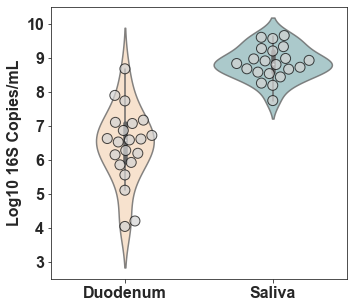

In [4]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig = plt.figure(figsize=(5.3,5))
ax1 = fig.add_subplot(111)

sns.violinplot(ax=ax1, x='Body_Site', y='Log Copies/mL', data=metadata, palette=['peachpuff', pal[0]], linewidth=1.5)
sns.swarmplot(ax=ax1, x='Body_Site', y='Log Copies/mL', data=metadata, color='lightgrey', s=10, alpha=0.7, edgecolor='k', linewidth=1)
ax1.set_ylim(2.5,10.5)
ax1.set_xlabel('')
ax1.set_ylabel('Log10 16S Copies/mL', fontsize=16, fontweight='bold')
ax1.set_title('', fontsize=16, fontweight='bold')

for violin, alpha in zip(ax1.collections[::2], [0.8, 0.8]):
    violin.set_alpha(alpha)


#fig.savefig('duo_saliva_load.png', dpi=200, bbox_inches='tight')
#fig.savefig('duo_saliva_load.pdf', bbox_inches='tight', transparent=True)

In [5]:
stats.kruskal(metadata[metadata['Body_Site']=='Duodenum']['Log Copies/mL'], metadata[metadata['Body_Site']=='Saliva']['Log Copies/mL'], nan_policy='omit')

KruskalResult(statistic=28.575383641828807, pvalue=9.012062002115988e-08)

Text(0.5, 0, 'Log10 Duodenum Load (16S Copies/mL)')

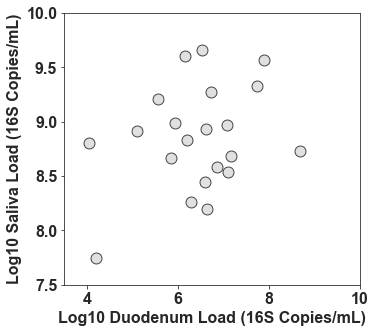

In [6]:
fig = plt.figure(figsize=(5.3,5))
ax1 = fig.add_subplot(111)

_df1 = metadata[(metadata['Body_Site']=='Duodenum')]
_df2 = metadata[(metadata['Body_Site']=='Saliva')]

ax1.scatter(x=_df1['Log Copies/mL'].tolist(), y=_df2['Log Copies/mL'].tolist(), s=120, alpha=0.7, edgecolor='k', linewidth=1, color='lightgrey')

ax1.set_ylim(7.5,10)
ax1.set_xlim(3.5,10)
ax1.set_ylabel('Log10 Saliva Load (16S Copies/mL)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Log10 Duodenum Load (16S Copies/mL)', fontsize=16, fontweight='bold')
#fig.savefig('saliva_duodenum_scatter.png', bbox_inches='tight', dpi=200)
#fig.savefig('saliva_duodenum_scatter.pdf', bbox_inches='tight', transparent=True)

In [7]:
stats.pearsonr(_df1['Log Copies/mL'].tolist(), _df2['Log Copies/mL'].tolist())

(0.29112067104605055, 0.20042533811557442)

## Calculate percent of taxa from duodenum samples present in paired saliva

In [8]:
# Generate boolean dataframe for presence/absence of species
df_bool = df_abs_sort_list[5].astype(bool)

# Get list of sample ids to iterate over
id_pairs = metadata[metadata['Body_Site']=='Duodenum']['Study ID'].tolist()

# Create copy to shuffle for randomization
id_pairs_shuffle = metadata[metadata['Body_Site']=='Duodenum']['Study ID'].tolist()

In [9]:
# Generate phased lists of sample ids for comparisons
id_pairs_phased = {}

for i in range(len(id_pairs)):
    if i==0:
        continue
    else:
        id_pairs_phased[i] = id_pairs[-i:]+id_pairs[:-i]

In [10]:
paired_unique_duo_dict = {}
random_unique_duo_dict = {}
paired_percent_duo_dict = {}
random_percent_duo_dict = {}

for i in range(len(id_pairs)):
    # Generate list of duodenum taxa that are present in the first paired sample ID
    duo_list = df_bool.loc[str(id_pairs[i])+'_Duo'][df_bool.loc[str(id_pairs[i])+'_Duo']==True].index.tolist()
    
    # Generate list of saliva taxa that are present in the first paired sample ID
    paired_sal_list = df_bool.loc[str(id_pairs[i])+'_Sal'][df_bool.loc[str(id_pairs[i])+'_Sal']==True].index.tolist()
    
    paired_unique_duo_list = []
    
    # Generate list of unique taxa only found in the paired duodenum sample
    for taxa in duo_list:
        if taxa not in paired_sal_list:
            paired_unique_duo_list.append(df_col_names_list[5].loc[taxa]['label'])
            
    #Create dictionary to hold unique taxa
    paired_unique_duo_dict[id_pairs[i]] = paired_unique_duo_list
    
    #Create dictionary to hold the percent of shared taxa
    paired_percent_duo_dict[id_pairs[i]] = (1-(len(paired_unique_duo_list)/len(duo_list)))*100
    
    # Initialize list to hold the 20 values for each sample
    random_percent_duo_dict[id_pairs[i]] = []
    
    # Generate list of saliva taxa that are present in each of the other samples
    for j in range(len(id_pairs)-1):
            random_sal_list = df_bool.loc[str(id_pairs_phased[j+1][i])+'_Sal'][df_bool.loc[str(id_pairs_phased[j+1][i])+'_Sal']==True].index.tolist()

            random_unique_duo_list = []
    
            # Generate list of unique taxa only found in paired saliva sample
            for taxa in duo_list:
                if taxa not in random_sal_list:
                    random_unique_duo_list.append(df_col_names_list[5].loc[taxa]['label'])
    
            # Create dictionary to hold unique taxa
            random_unique_duo_dict[id_pairs[i]] = random_unique_duo_list
            
            random_percent_duo_dict[id_pairs[i]].append((1-(len(random_unique_duo_list)/len(duo_list)))*100)

In [11]:
df_permutations = pd.DataFrame.from_dict(random_percent_duo_dict)

mean_perm = df_permutations.mean(axis=0).tolist()

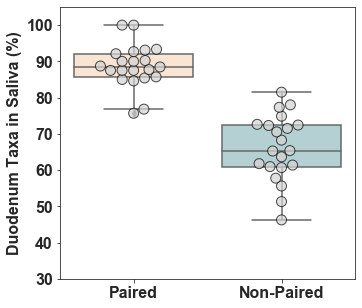

In [12]:
fig = plt.figure(figsize=(5.3,5))
ax1 = fig.add_subplot(111)

_df = pd.DataFrame({'Paired':list(paired_percent_duo_dict.values()), 'Non-Paired':mean_perm})
_df_melt = pd.melt(_df, value_name='Percent', var_name='Type')

sns.boxplot(ax=ax1, x='Type', y='Percent', data=_df_melt, palette=['peachpuff', pal[0]], linewidth=1.5)
sns.swarmplot(ax=ax1, x='Type', y='Percent', data=_df_melt, color='lightgrey', s=10, alpha=0.7, edgecolor='k', linewidth=1)
ax1.set_ylim(30,105)
ax1.set_title('', fontsize=16, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Duodenum Taxa in Saliva (%)', fontsize=16, fontweight='bold')

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))

#fig.savefig('paired_vs_random.png', dpi=200, bbox_inches='tight')
#fig.savefig('paired_vs_random.pdf', bbox_inches='tight', transparent=True)

In [13]:
stats.kruskal(_df_melt[_df_melt['Type']=='Paired']['Percent'].tolist(), _df_melt[_df_melt['Type']=='Non-Paired']['Percent'].tolist())

KruskalResult(statistic=29.12996699287741, pvalue=6.768196377616438e-08)

In [14]:
_df.mean()

Paired        88.671095
Non-Paired    66.162082
dtype: float64

In [15]:
_df.std()

Paired        5.898383
Non-Paired    9.090338
dtype: float64